In [18]:
import datetime as dt
import numpy as np
import xarray as xr

import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import xarray_regrid
import subprocess
from joblib import Parallel, delayed
import dask.array as da

In [19]:
#make a download directory
import os
if not os.path.exists('download'):
    os.makedirs('download')
if not os.path.exists('figures'):
    os.makedirs('figures')

In [20]:
download = True

## Load Data

In [21]:
cfsv2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cfsv2_path = 'download/cfsv2_precip_fcast.nc'

gfdlspear_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
gfdlspear_path = 'download/gfdlspear_precip_fcast.nc'

cansipsic4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC4/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cansipsic4_path = 'download/cansipsic4_precip_fcast.nc'

cesm1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CESM1/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cesm1_path = 'download/cesm1_precip_fcast.nc'

colaccsm4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
colaccsm4_path = 'download/colaccsm4_precip_fcast.nc'

nasageos_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos_path = 'download/nasageos_precip_fcast.nc'

if download:
    print(cfsv2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cfsv2_url, '-o', cfsv2_path])
    print(gfdlspear_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', gfdlspear_url, '-o', gfdlspear_path])
    print(cesm1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cesm1_url, '-o', cesm1_path])
    print(colaccsm4_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', colaccsm4_url, '-o', colaccsm4_path])
    print(nasageos_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos_url, '-o', nasageos_path])

    #print(cansipsic4_url)
    #subprocess.call(['curl', '-b', 'cookies.txt', '-k', cansipsic4_url, '-o', cansipsic4_path])
    

https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc
https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc
https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CESM1/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc
https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc
https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [22]:
cfsv2 = xr.open_dataset(cfsv2_path, decode_times=True)
gfdlspear = xr.open_dataset(gfdlspear_path, decode_times=True)
cesm1 = xr.open_dataset(cesm1_path, decode_times=True)
colaccsm4 = xr.open_dataset(colaccsm4_path, decode_times=True)
nasageos = xr.open_dataset(nasageos_path, decode_times=True)
#cansipsic4 = xr.open_dataset(cansipsic4_path, decode_times=True)

In [23]:
cmap_url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cmap_path = 'download/cmap_precip.nc'

print(cmap_url)
subprocess.call(['curl', '-b', 'cookies.txt', '-k', cmap_url, '-o', cmap_path])

cmap = xr.open_dataset(cmap_path, decode_times=True)
#change datetime to 01-MM-YYYY
new_dates = pd.to_datetime(cmap['T'].values, format="%d-%m-%Y").strftime("01-%m-%Y")
cmap['T'] = pd.to_datetime(new_dates, format="%d-%m-%Y")
obs = cmap['prcp_est']

obs_3m = obs + obs.shift(T=1) + obs.shift(T=2)
obs_3m = obs_3m.dropna('T')


https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [25]:
spi_obs = xr.load_dataset('data/spi3_cmap_1x1.nc')
#rename variable __xarray_dataarray_variable__ to spi
spi_obs = spi_obs.rename({'__xarray_dataarray_variable__':'spi'}).spi.sortby('T')


## Forecast

In [26]:
nmme_dict =  {'cfsv2': cfsv2, 'gfdlspear': gfdlspear, 'cesm1': cesm1, 'colaccsm4': colaccsm4, 'nasageos': nasageos}

precip_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cesm1': None, 'colaccsm4': None, 'nasageos': None}
spi_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cesm1': None, 'colaccsm4': None, 'nasageos': None}

nmme_dict =  {'cfsv2': cfsv2, 'gfdlspear': gfdlspear}
precip_fcast_dict = {'cfsv2': None, 'gfdlspear': None}
spi_fcast_dict = {'cfsv2': None, 'gfdlspear': None}

In [ ]:
n_lead = 3
for (nmme_name, nmme) in nmme_dict.items():
    print(f"######################")
    print(f"Processing NMME: {nmme_name.upper()}")
    print(f"######################")
    P_bar_all = nmme.mean(dim='M')['prec']
    P_bar = P_bar_all.sel(S=slice('2023-01-01','2024-12-31'))
    fcast_starts = P_bar['S'].values
    # Initialize storage
    x_range = P_bar['X'].values
    y_range = P_bar['Y'].values

    P_storage = np.full((len(fcast_starts), n_lead, len(y_range), len(x_range)), np.nan)
    spi_storage = np.full((len(fcast_starts), n_lead, len(y_range), len(x_range)), np.nan)

    # Define a function to compute SPI for a single grid point
    def compute_spi_single_grid(i, j, blend_series_season, s,l):
        data_grid = blend_series_season.sel(X=x_range[j], Y=y_range[i])
        t = s + pd.DateOffset(months=int(l))
        t_month = t.month
        data_grid_month = data_grid.sel(T=data_grid['T.month'] == t_month).values

        if np.all(np.isnan(data_grid_month)):  # Skip if all values are NaN
            return np.nan

        # Fit Pearson Type III distribution
        try:
            a, loc, scale = sp.stats.pearson3.fit(data_grid_month)
            cdf_values = sp.stats.pearson3.cdf(data_grid_month, skew=a, loc=loc, scale=scale)

            # Handle zero-inflated data
            q = np.sum(data_grid_month == 0) / len(data_grid_month)
            cdf_values = (cdf_values * (1 - q)) + q

            # Ensure CDF is within valid bounds
            cdf_values = np.clip(cdf_values, 1e-6, 1 - 1e-6)

            # Convert CDF to SPI
            spi_time_series = sp.stats.norm.ppf(cdf_values)
            return spi_time_series[-1]
        except Exception as e:
            print(f"Error fitting distribution at (X={x_range[j]}, Y={y_range[i]}): {e}")
            return np.nan

    # Process each forecast start
    for s in range(len(fcast_starts)):
        print(f"Computing SPI for forecast starting {fcast_starts[s]}")
        fcast_start = fcast_starts[s].astype('datetime64[s]').item()
        month = fcast_start.month

        # Compute climatology and anomalies
        P_bar_month = P_bar.sel(S=P_bar['S.month'] == month)
        P_c = P_bar_month.where(P_bar_month['S'] != fcast_starts[s]).mean(dim='S')
        P_a = P_bar - P_c

        ty_1 = fcast_start - relativedelta(years=1)
        ty_30 = fcast_start - relativedelta(years=30)

        obs_month = obs.sel(T=obs['T.month'] == month)
        obs_climo = obs_month.sel(T=slice(ty_30, ty_1)).mean(dim='T')
        P_fcst = P_a + obs_climo
        P_fcst_s = P_fcst.sel(S=fcast_start)
        # Create a new xarray with T as a dimension
        L_values = np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5,6.5,7.5])[0:n_lead]
        T_values = [fcast_start + pd.DateOffset(months=int(L - 0.5)) for L in L_values]
        P_fcst = xr.concat(
            [P_fcst_s.sel(L=L).expand_dims(T=[T]) for L, T in zip(L_values, T_values)],
            dim="T"
        ).drop_vars('L')

        P_obs = obs.sel(T=slice(ty_30, fcast_start - relativedelta(months=1)))
        blend_series = xr.concat([P_obs, P_fcst], dim='T').sortby('T')
        blend_series_season = blend_series + blend_series.shift(T=1) + blend_series.shift(T=2)
        blend_series_season = blend_series_season.dropna('T').sortby('T')
        for l in range(n_lead):
            P_storage[s, l, :, :] = blend_series_season.isel(T=-n_lead+l).values

        # Parallelize SPI computation across grid points
        def compute_spi_for_time(s,l):
            return Parallel(n_jobs=-1)(
                delayed(compute_spi_single_grid)(i, j, blend_series_season, s,l)
                for i in range(len(y_range))
                for j in range(len(x_range))
            )

        # Store SPI results
        for l in range(n_lead):
            print(f"-Computing SPI for lead time {l + 1}")
            results = compute_spi_for_time(s=fcast_start, l=l)
            spi_storage[s, l, :, :] = np.array(results).reshape(len(y_range), len(x_range))


    # Convert SPI storage to an xarray
    spi_s = xr.DataArray(
        spi_storage,
        dims=['S', 'L', 'Y', 'X'],
        coords={'S': fcast_starts, 'L': L_values, 'Y': y_range, 'X': x_range},
        name='spi'
    )

    P_s = xr.DataArray(
        P_storage,
        dims=['S', 'L', 'Y', 'X'],
        coords={'S': fcast_starts, 'L': L_values, 'Y': y_range, 'X': x_range},
        name='precip')
    

    # Concatenate all forecasts
    P_fcst = xr.concat(P_s, dim='S')
    spi_fcst = xr.concat(spi_s, dim='S')

    # Store the results
    precip_fcast_dict[nmme_name] = P_fcst
    spi_fcast_dict[nmme_name] = spi_fcst
    # Save the results
    P_fcst.to_netcdf(f'data/precip_fcast_{nmme_name}_2324.nc')
    spi_fcst.to_netcdf(f'data/spi_fcast_{nmme_name}_2324.nc')



######################
Processing NMME: CFSV2
######################
Computing SPI for forecast starting 2023-01-01T00:00:00.000000000
-Computing SPI for lead time 1
-Computing SPI for lead time 2
-Computing SPI for lead time 3
Computing SPI for forecast starting 2023-02-01T00:00:00.000000000
-Computing SPI for lead time 1
-Computing SPI for lead time 2
-Computing SPI for lead time 3
Computing SPI for forecast starting 2023-03-01T00:00:00.000000000
-Computing SPI for lead time 1
-Computing SPI for lead time 2
-Computing SPI for lead time 3
Computing SPI for forecast starting 2023-04-01T00:00:00.000000000
-Computing SPI for lead time 1
-Computing SPI for lead time 2
-Computing SPI for lead time 3
Computing SPI for forecast starting 2023-05-01T00:00:00.000000000
-Computing SPI for lead time 1
-Computing SPI for lead time 2
-Computing SPI for lead time 3
Computing SPI for forecast starting 2023-06-01T00:00:00.000000000
-Computing SPI for lead time 1
-Computing SPI for lead time 2
-Computi

In [13]:
spi_fcast_multimodel = xr.concat([spi_fcast_dict[nmme_name] for nmme_name in nmme_dict.keys()], dim='nmme').mean(dim='nmme')
spi_fcast_multimodel.to_netcdf(f'data/spi_fcast_multimodel_2324.nc')

precip_fcast_multimodel = xr.concat([precip_fcast_dict[nmme_name] for nmme_name in nmme_dict.keys()], dim='nmme').mean(dim='nmme')
precip_fcast_multimodel.to_netcdf(f'data/precip_fcast_multimodel_2324.nc')

## Skill

In [14]:
n_lead= 6

In [15]:
spi_fcast_multimodel = xr.load_dataset('data/spi_fcast_multimodel_2324.nc')
precip_fcast_multimodel = xr.load_dataset('data/precip_fcast_multimodel_2324.nc')

In [16]:
spi_fcast_multimodel = spi_fcast_multimodel.spi
precip_fcast_multimodel = precip_fcast_multimodel.precip

Processing month 1 with lead time 1
Processing month 1 with lead time 2
Processing month 1 with lead time 3
Processing month 1 with lead time 4
Processing month 1 with lead time 5
Processing month 1 with lead time 6
Processing month 2 with lead time 1
Processing month 2 with lead time 2
Processing month 2 with lead time 3
Processing month 2 with lead time 4
Processing month 2 with lead time 5
Processing month 2 with lead time 6
Processing month 3 with lead time 1
Processing month 3 with lead time 2
Processing month 3 with lead time 3
Processing month 3 with lead time 4
Processing month 3 with lead time 5
Processing month 3 with lead time 6
Processing month 4 with lead time 1
Processing month 4 with lead time 2
Processing month 4 with lead time 3


C:\Users\emile\AppData\Local\Temp\ipykernel_3932\2874464141.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(


Processing month 4 with lead time 4
Processing month 4 with lead time 5
Processing month 4 with lead time 6
Processing month 5 with lead time 1
Processing month 5 with lead time 2
Processing month 5 with lead time 3
Processing month 5 with lead time 4
Processing month 5 with lead time 5
Processing month 5 with lead time 6
Processing month 6 with lead time 1
Processing month 6 with lead time 2
Processing month 6 with lead time 3
Processing month 6 with lead time 4
Processing month 6 with lead time 5
Processing month 6 with lead time 6
Processing month 7 with lead time 1
Processing month 7 with lead time 2
Processing month 7 with lead time 3
Processing month 7 with lead time 4
Processing month 7 with lead time 5
Processing month 7 with lead time 6
Processing month 8 with lead time 1
Processing month 8 with lead time 2
Processing month 8 with lead time 3
Processing month 8 with lead time 4
Processing month 8 with lead time 5
Processing month 8 with lead time 6
Processing month 9 with lead

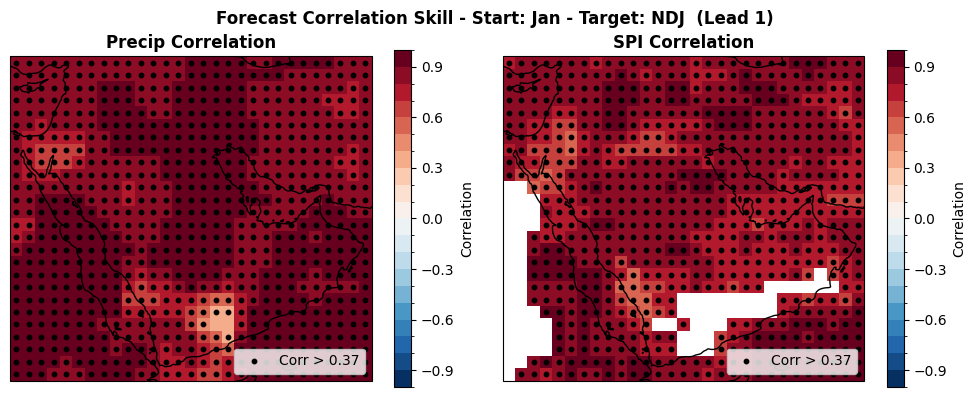

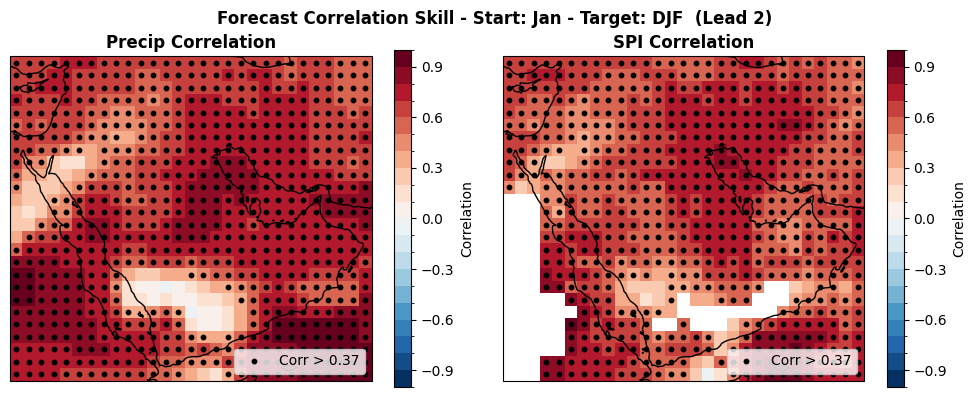

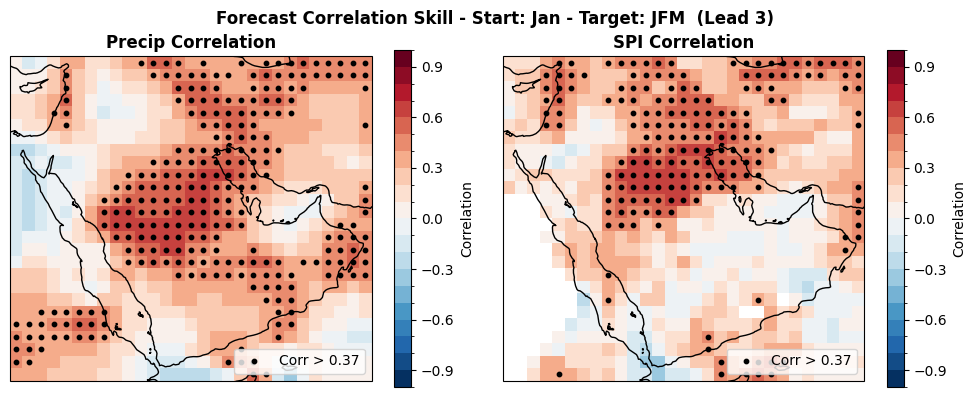

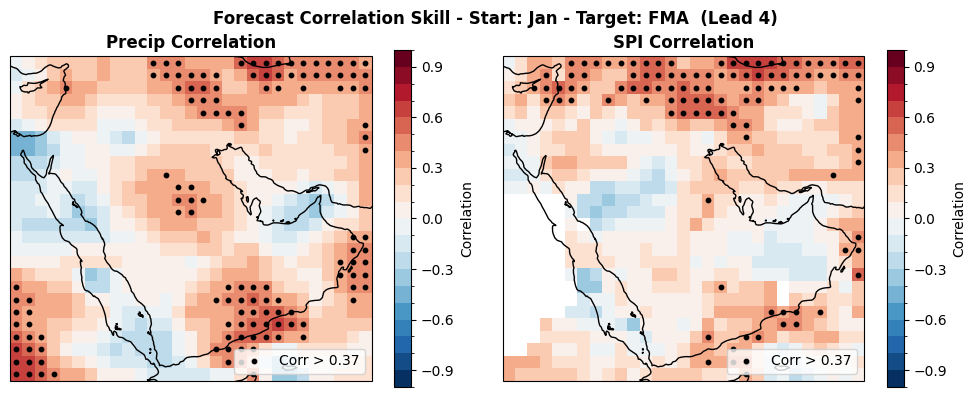

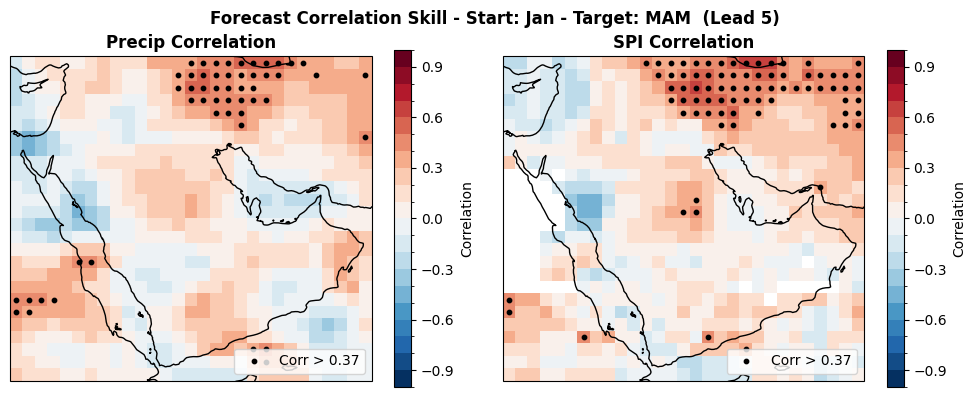

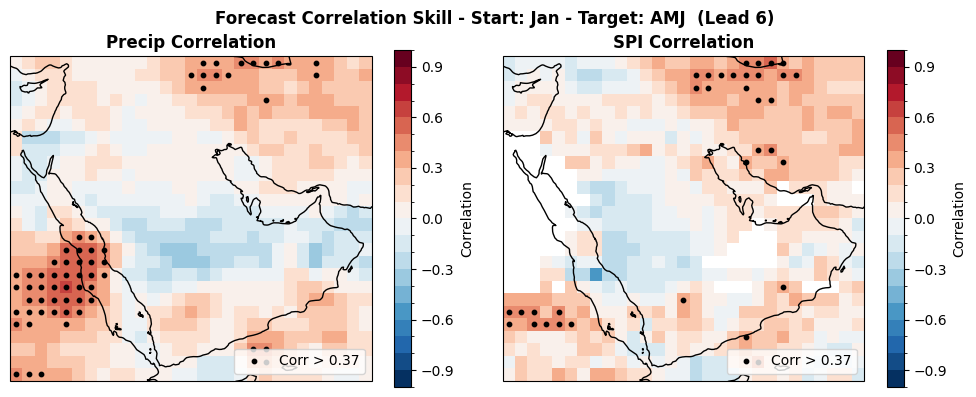

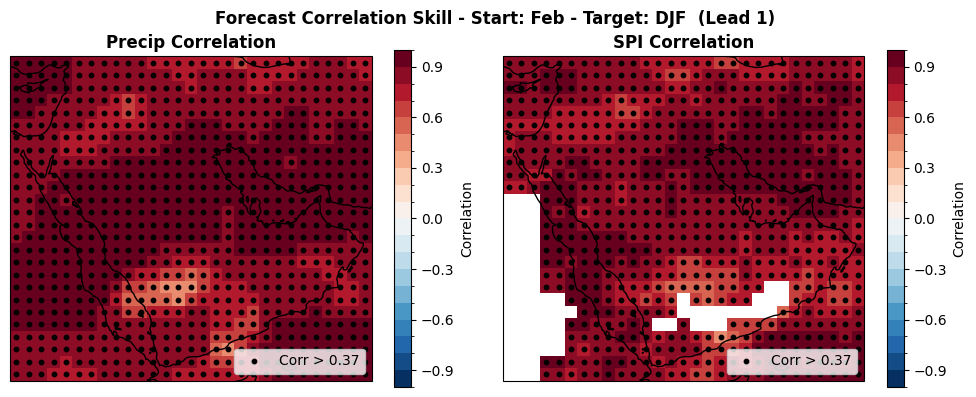

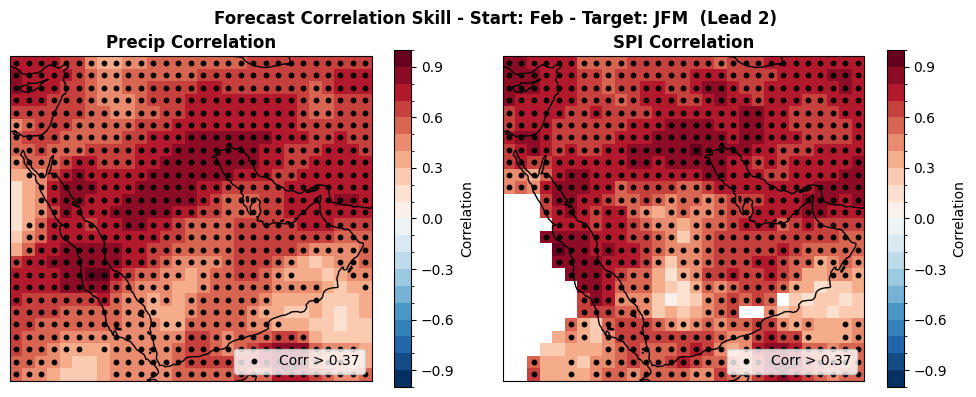

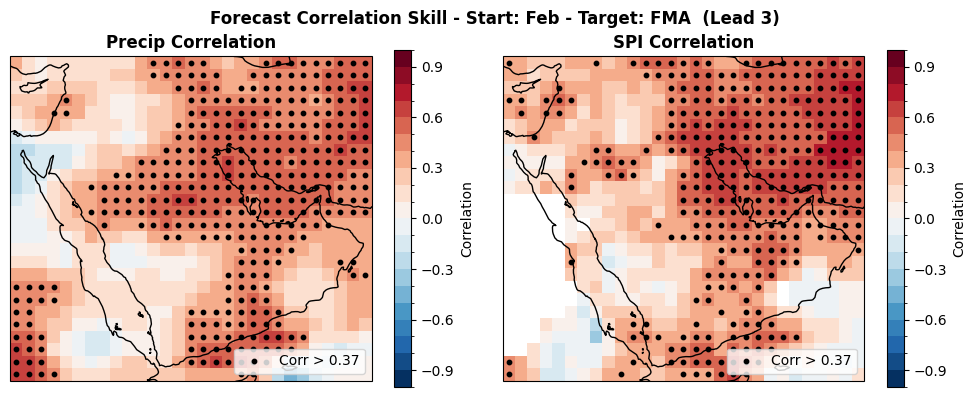

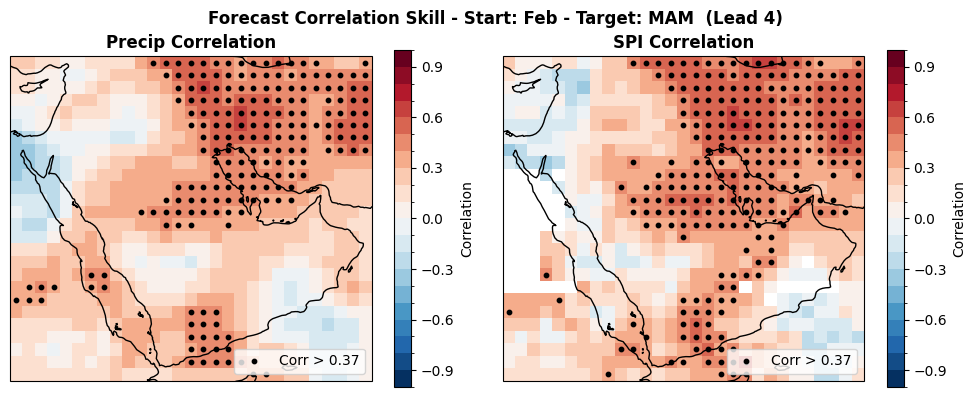

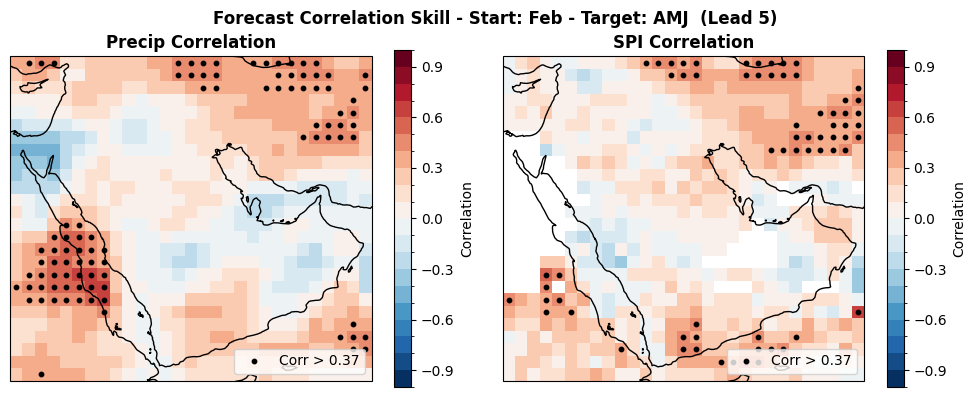

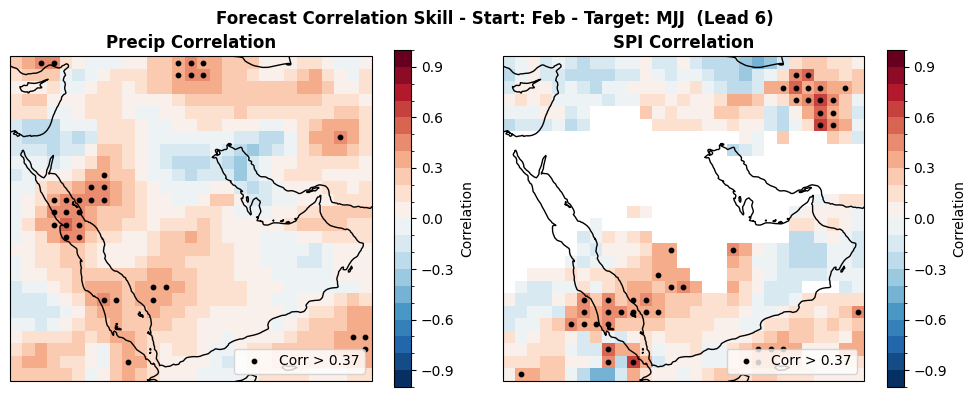

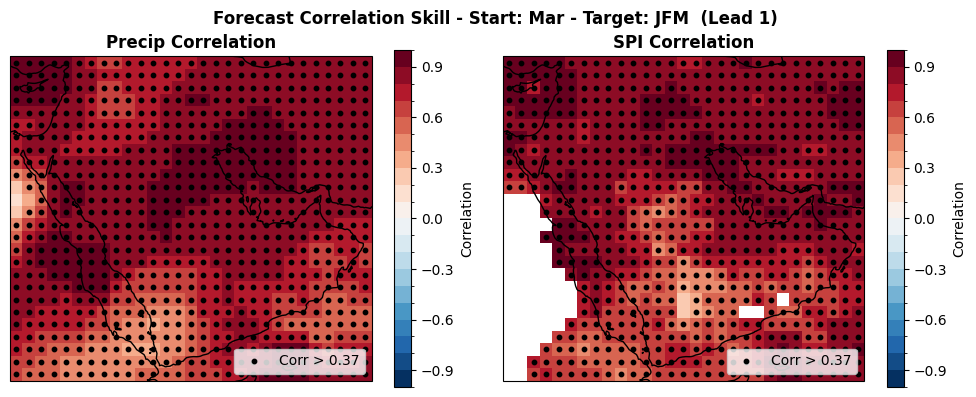

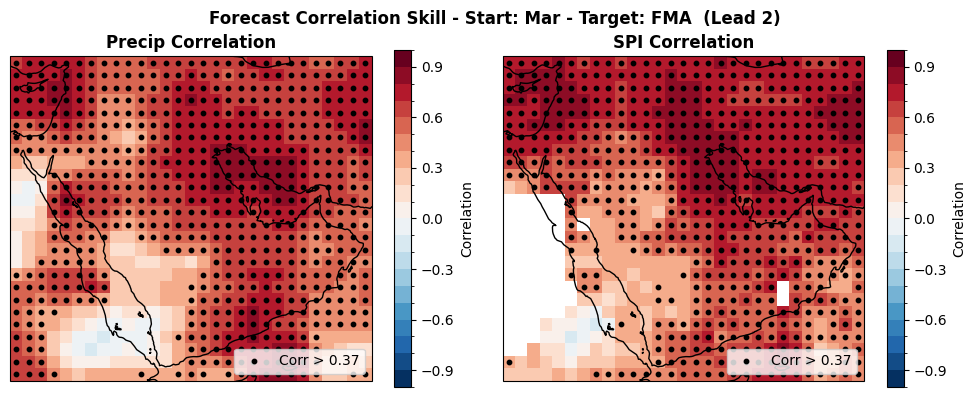

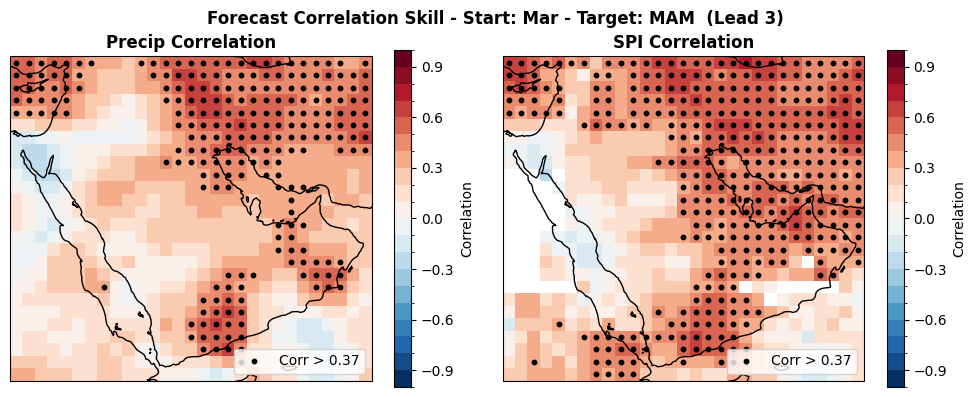

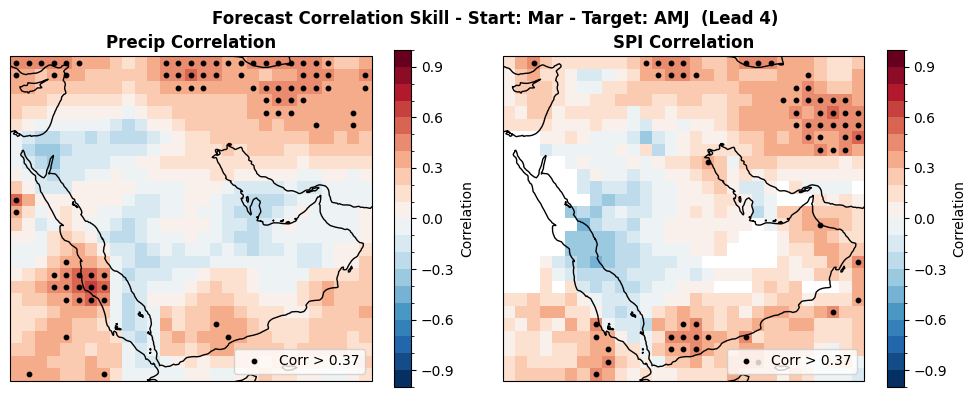

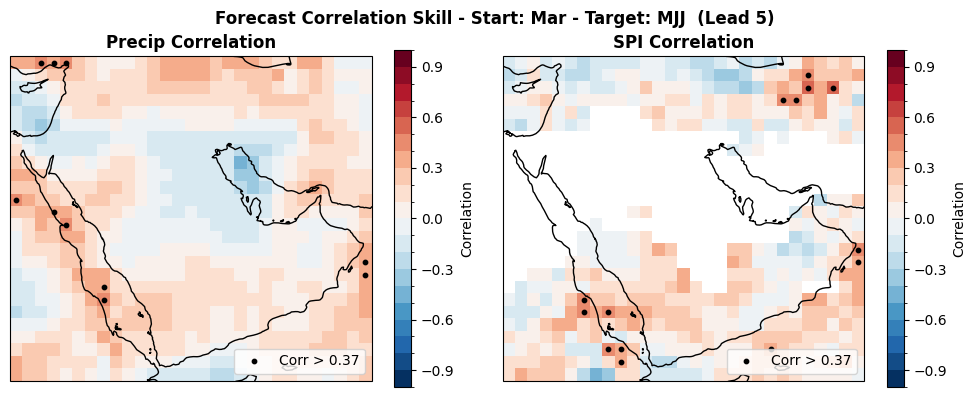

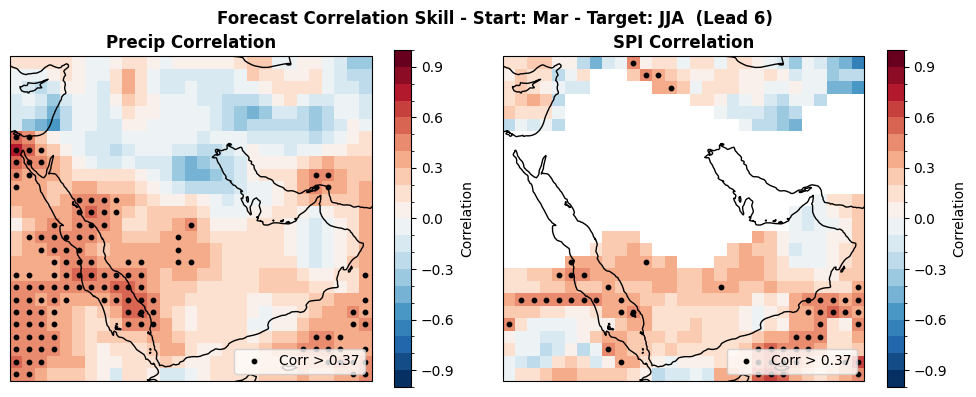

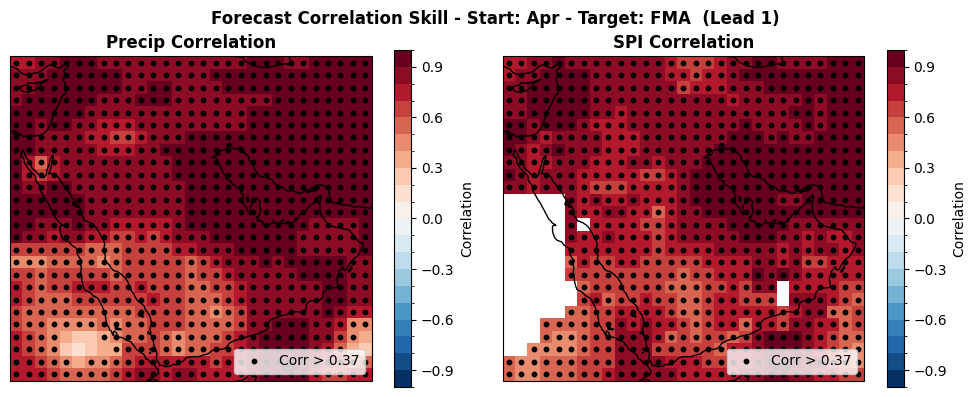

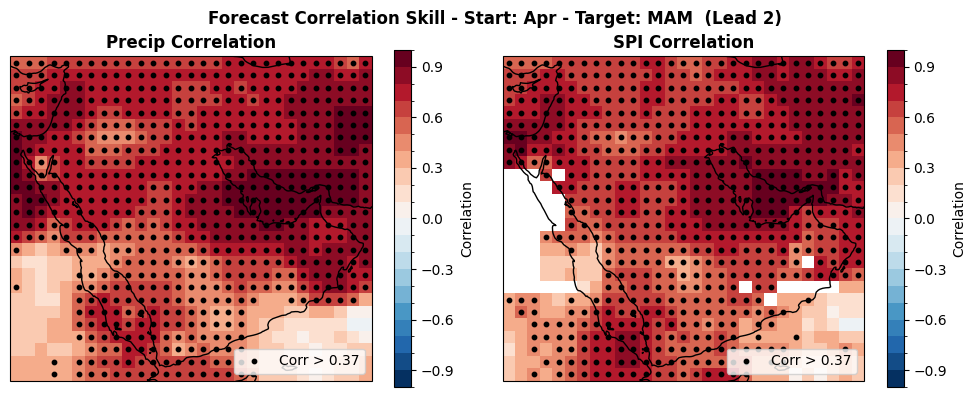

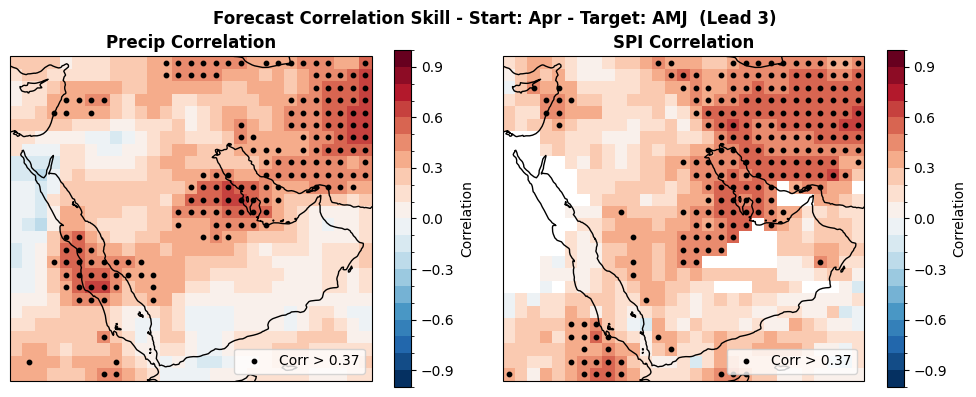

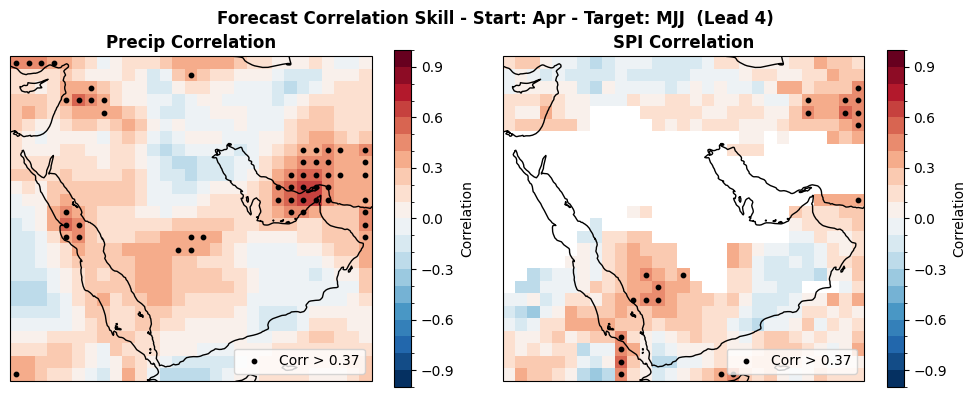

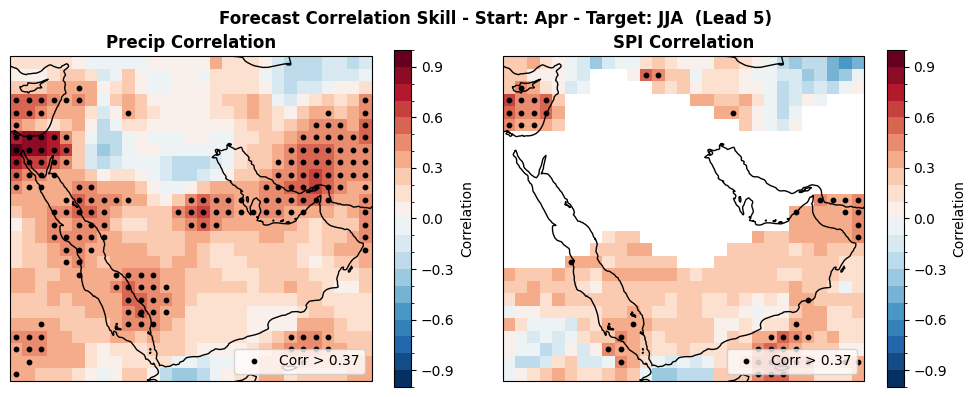

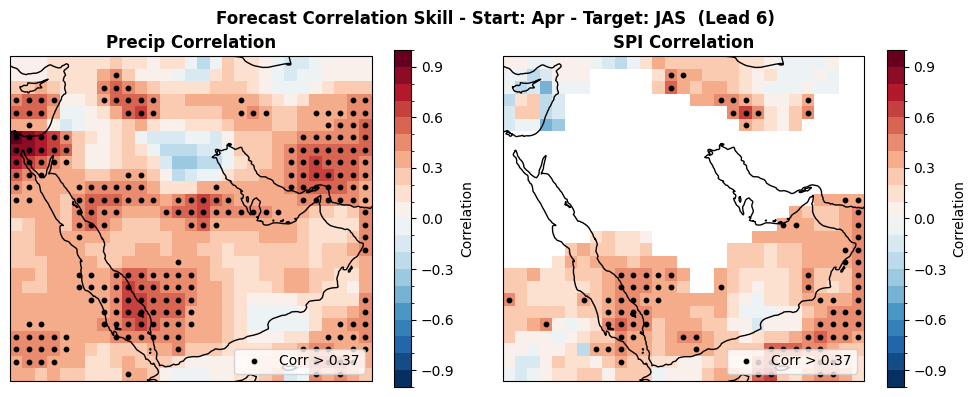

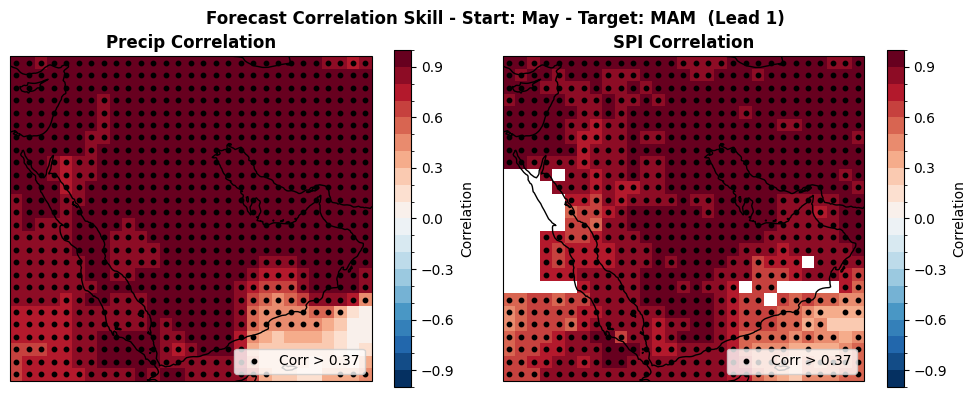

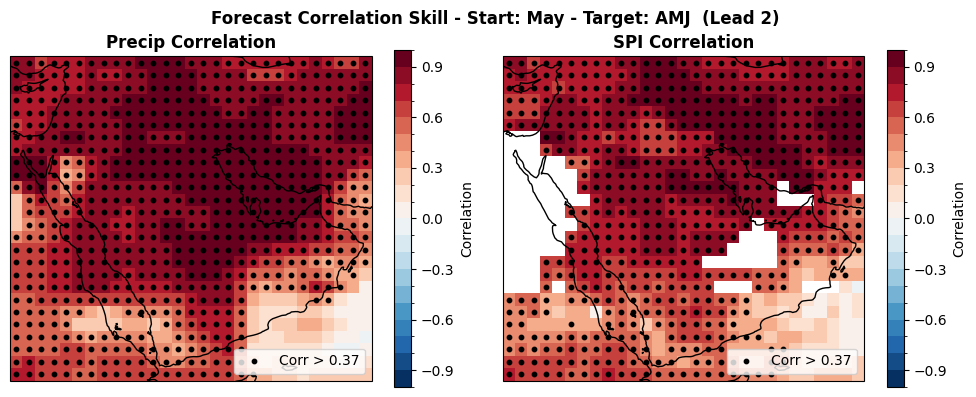

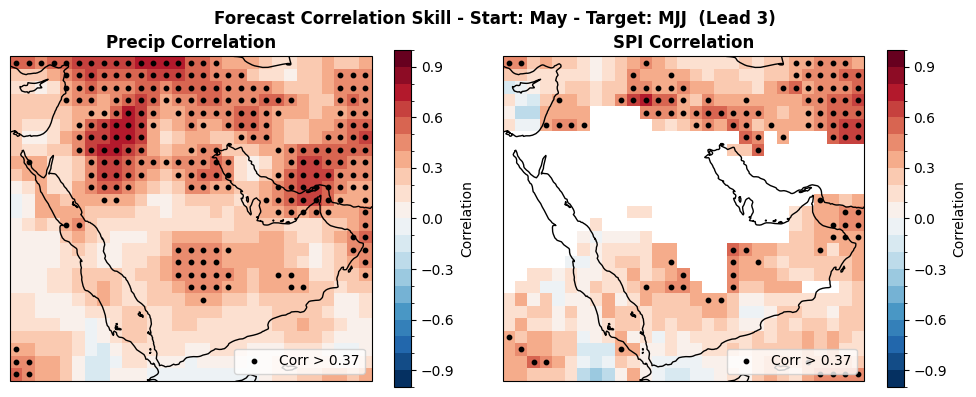

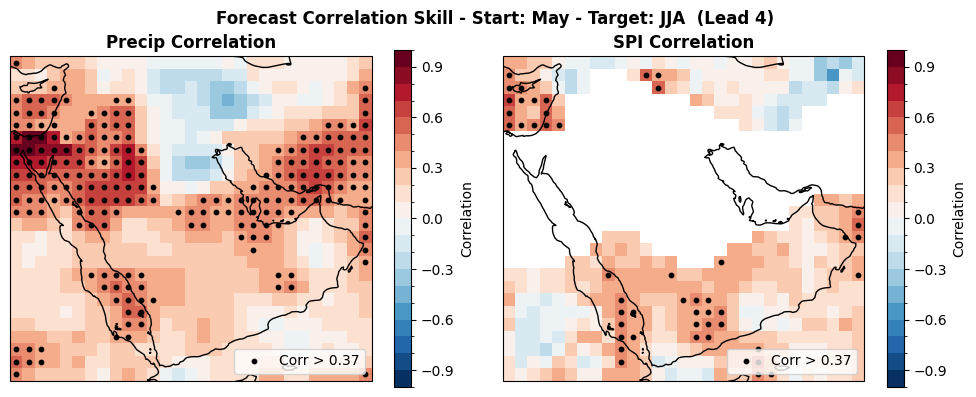

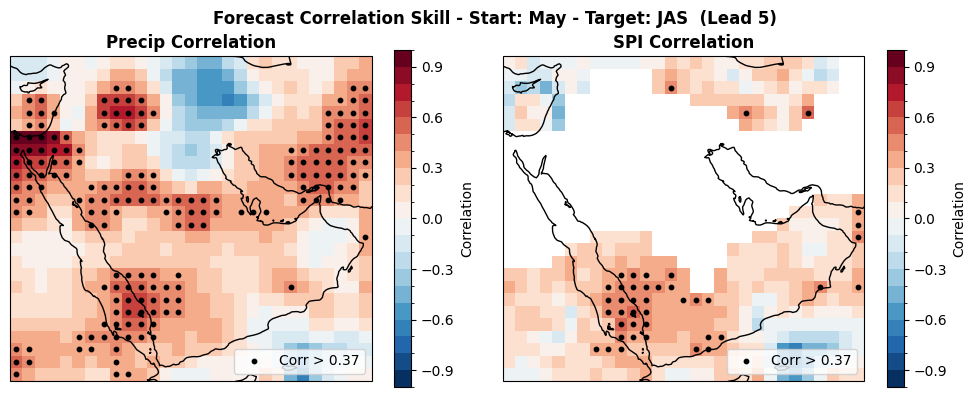

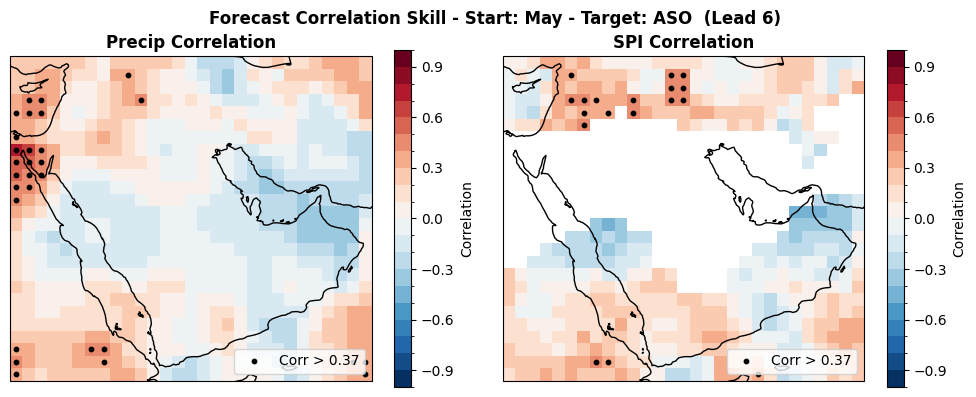

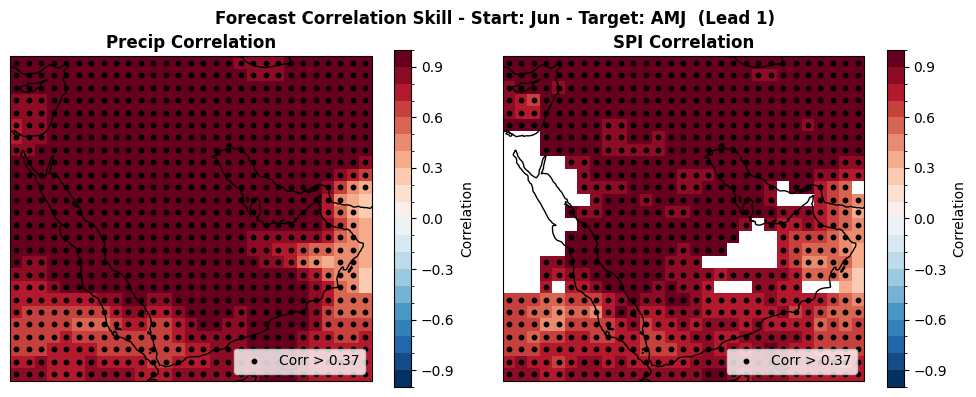

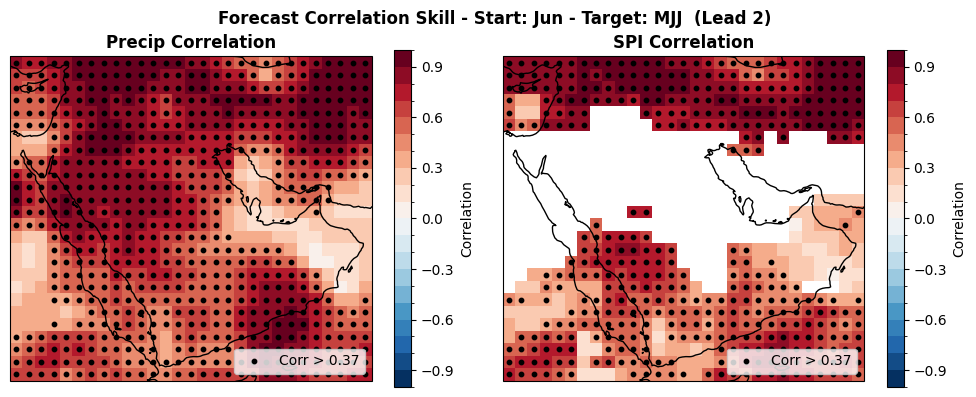

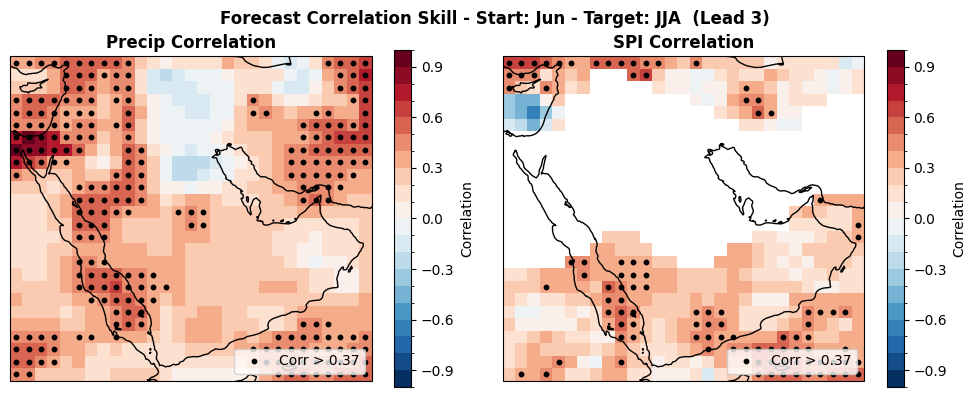

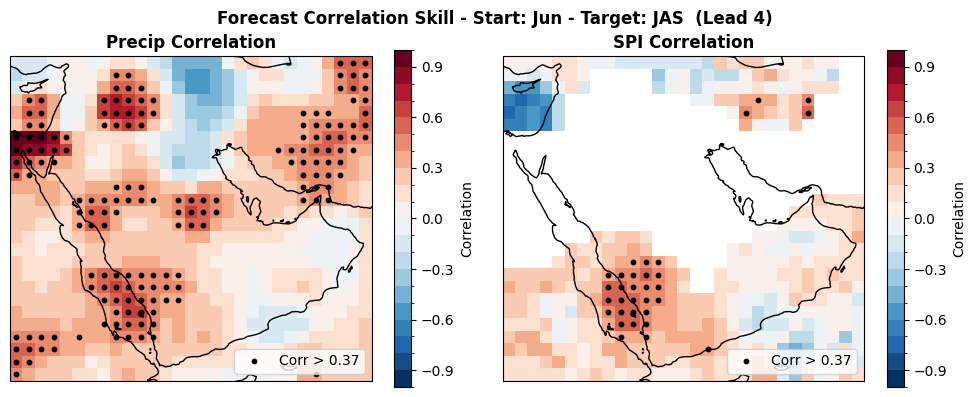

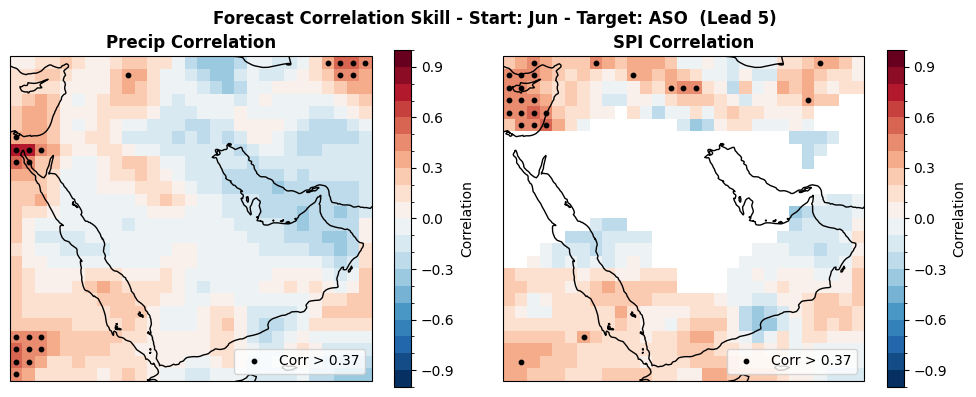

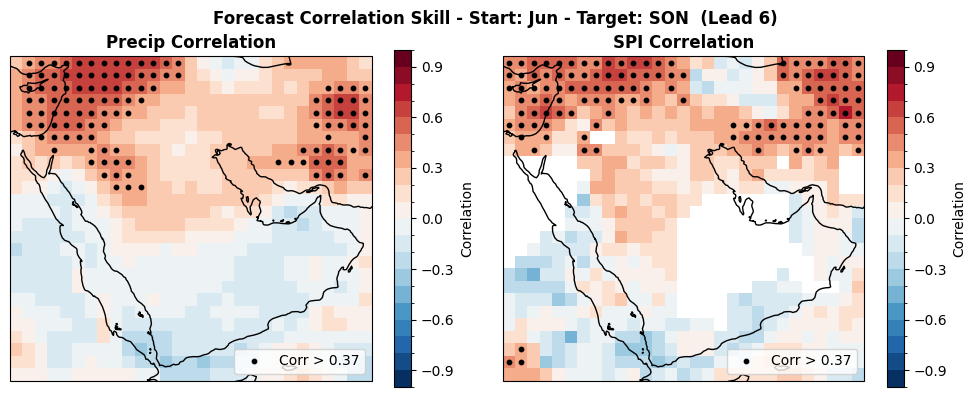

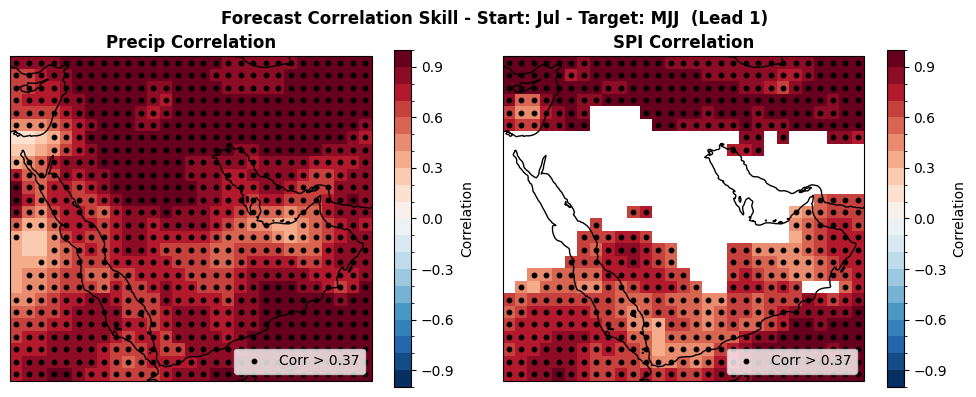

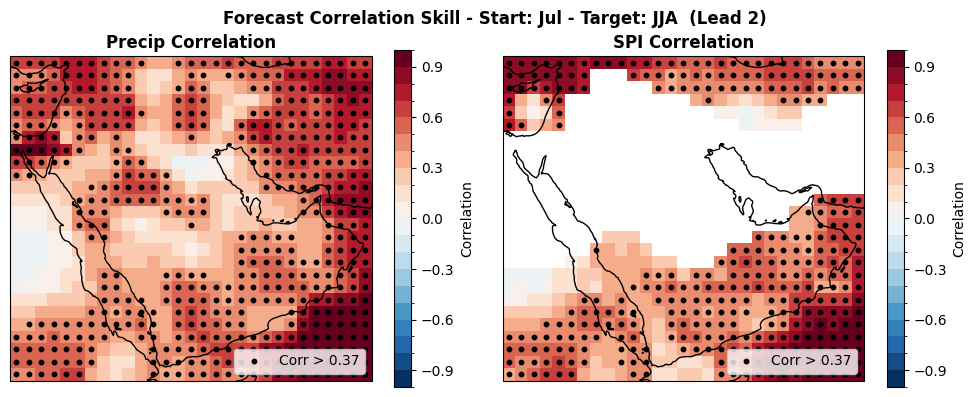

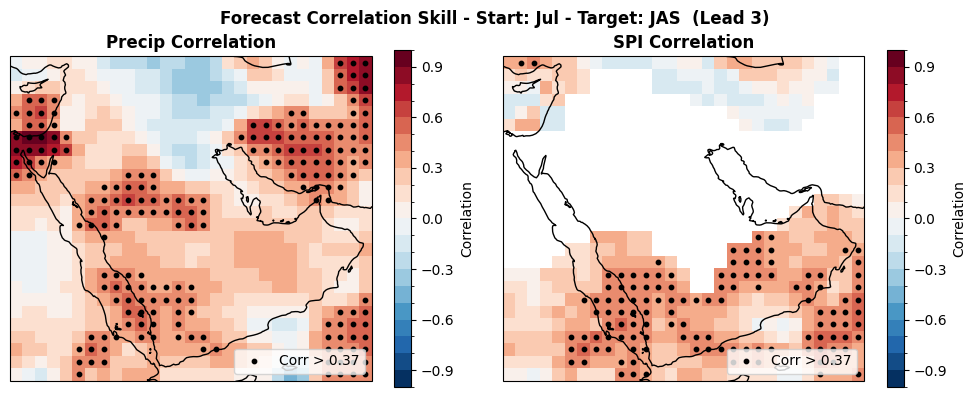

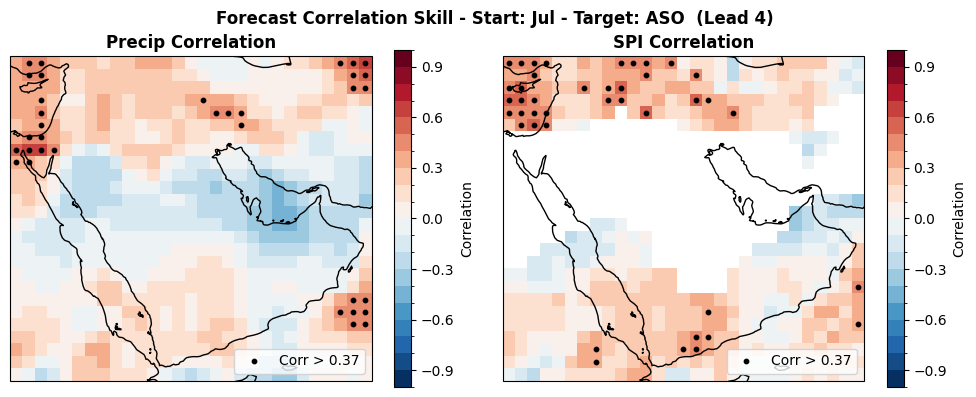

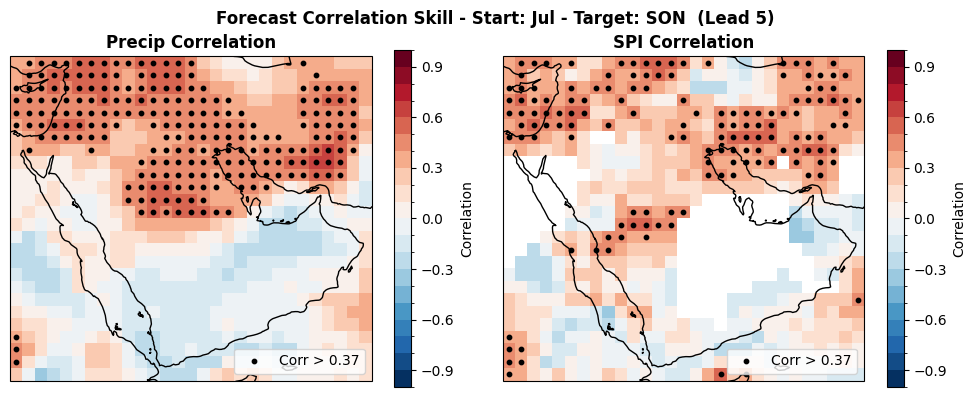

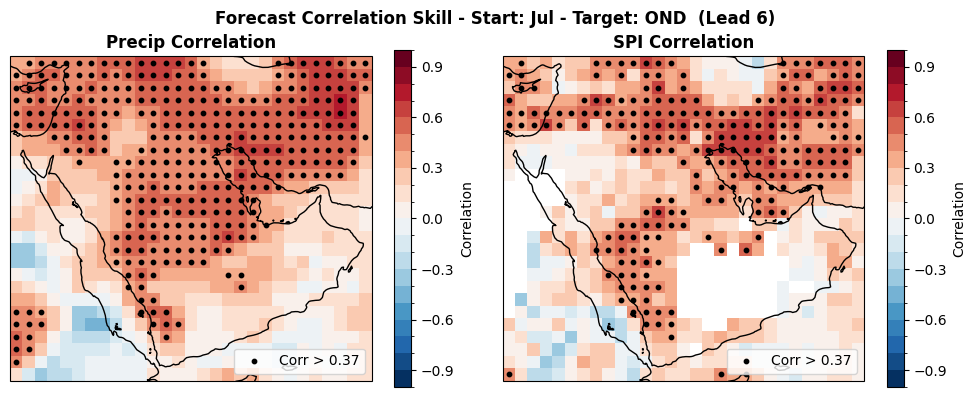

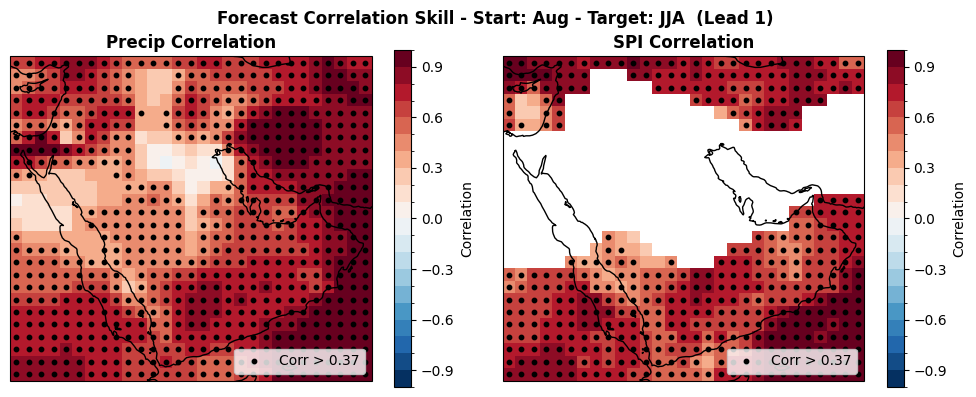

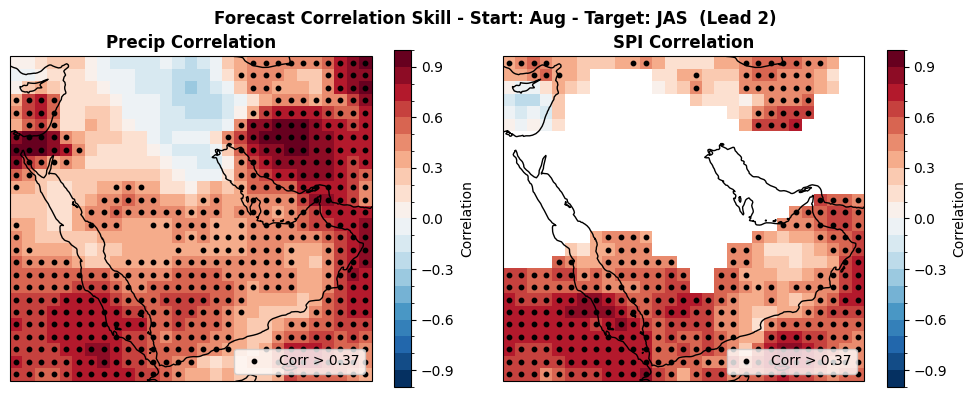

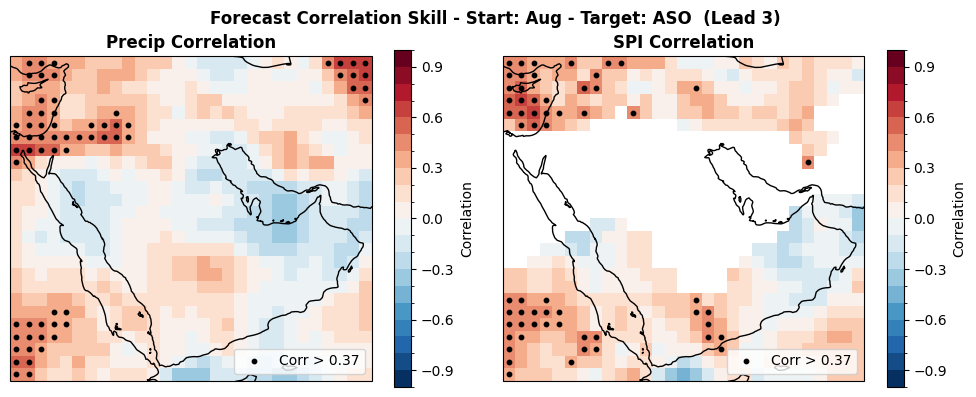

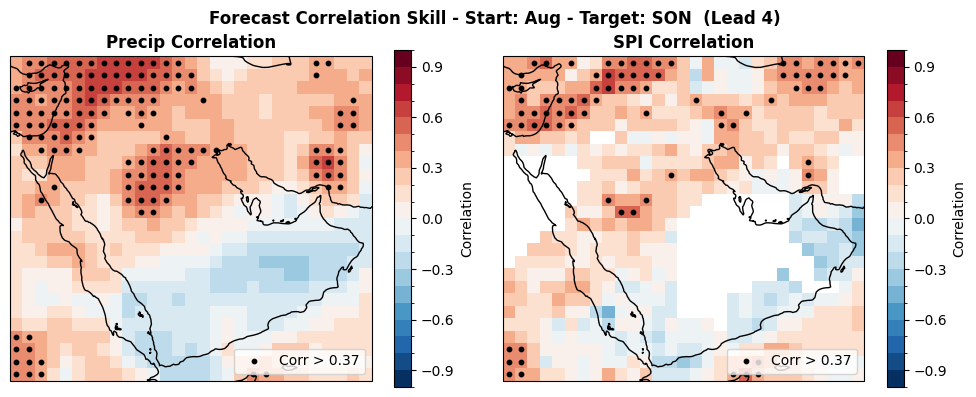

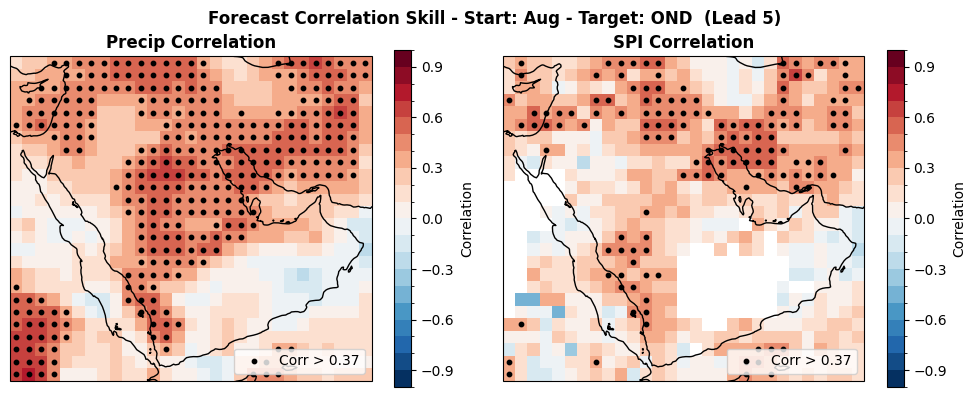

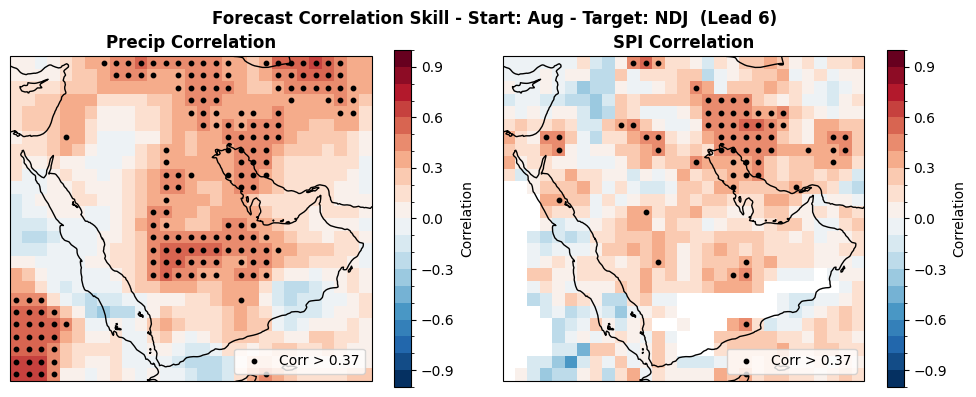

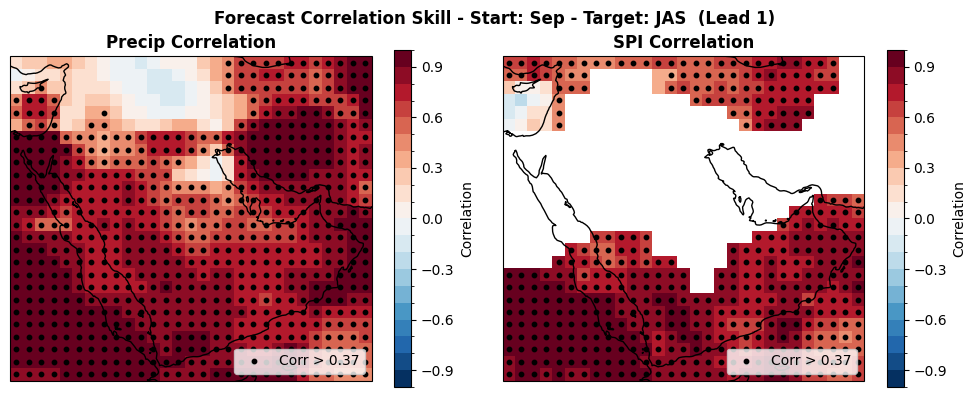

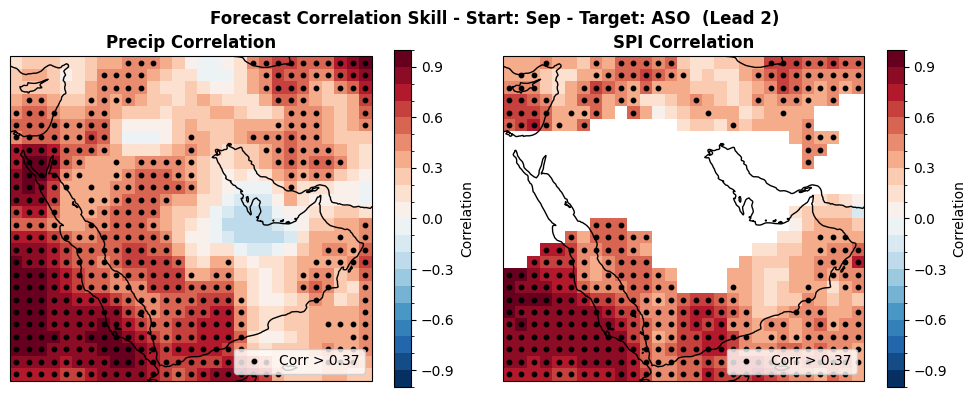

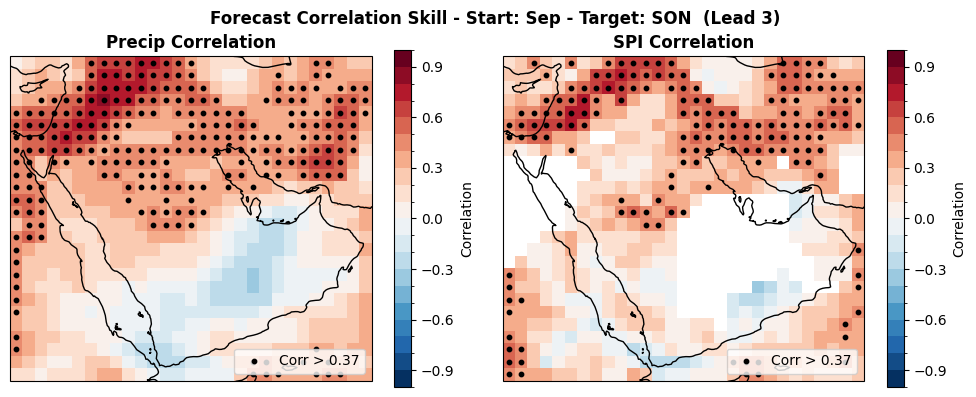

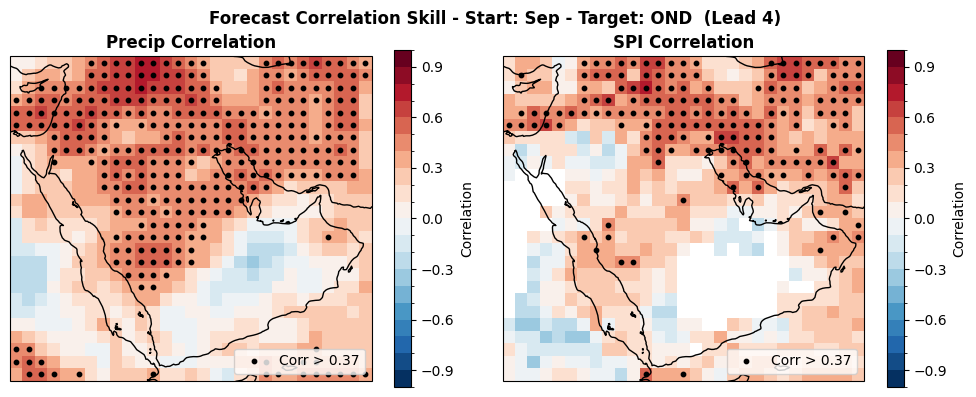

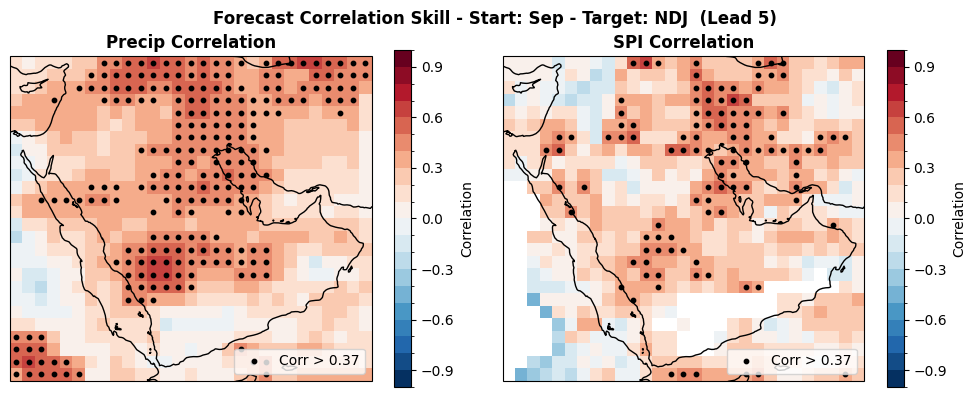

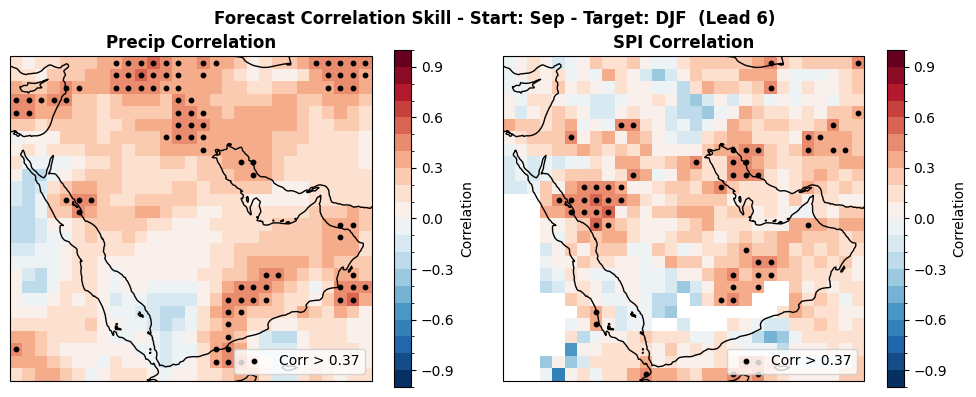

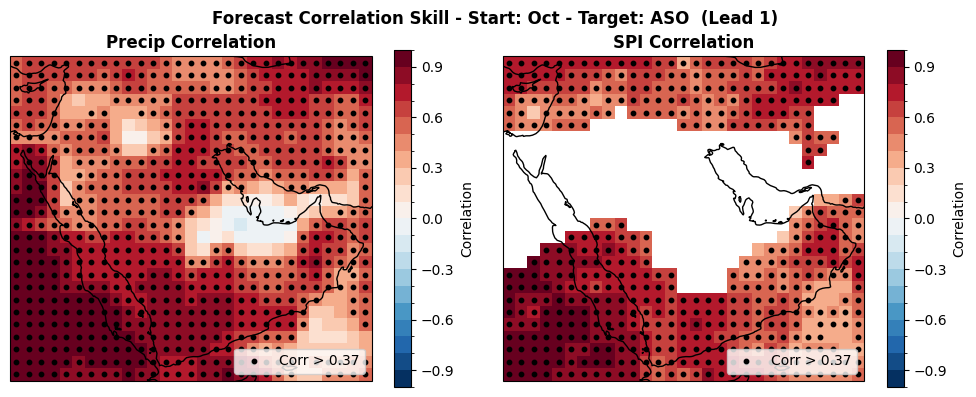

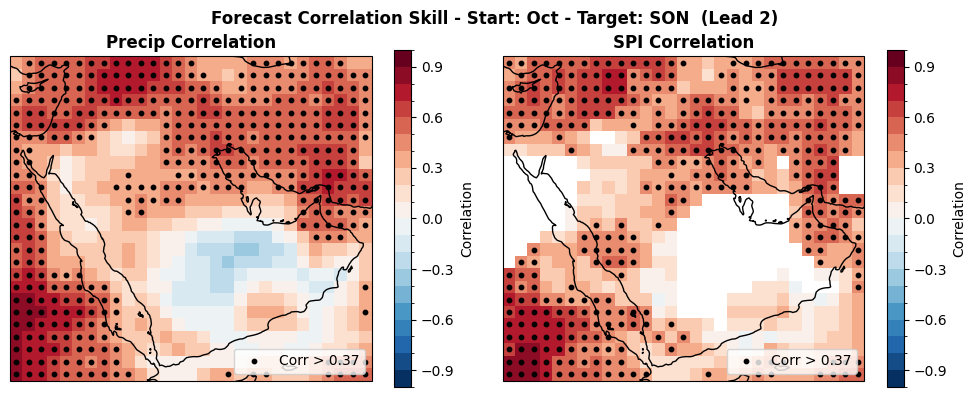

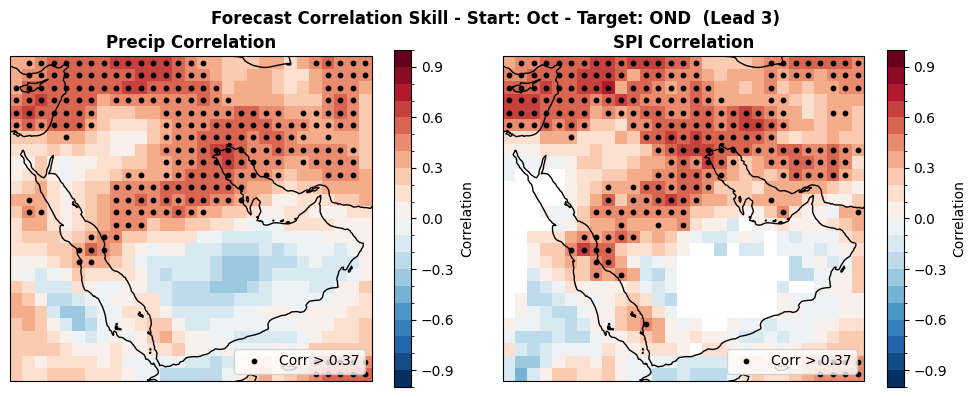

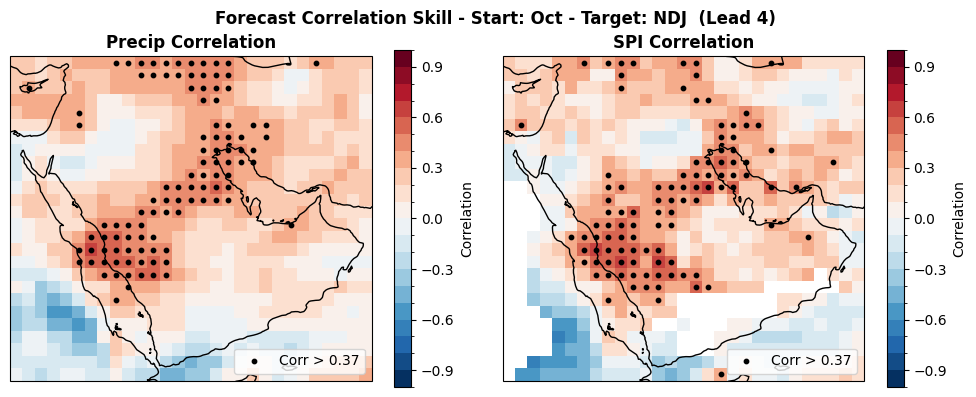

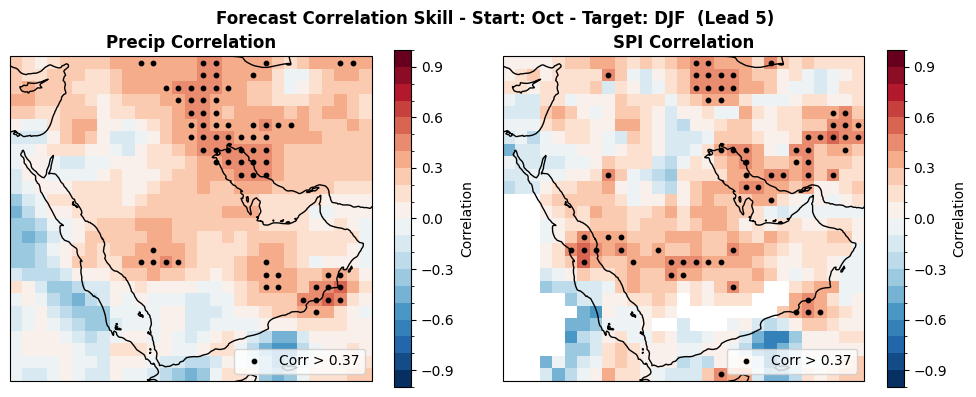

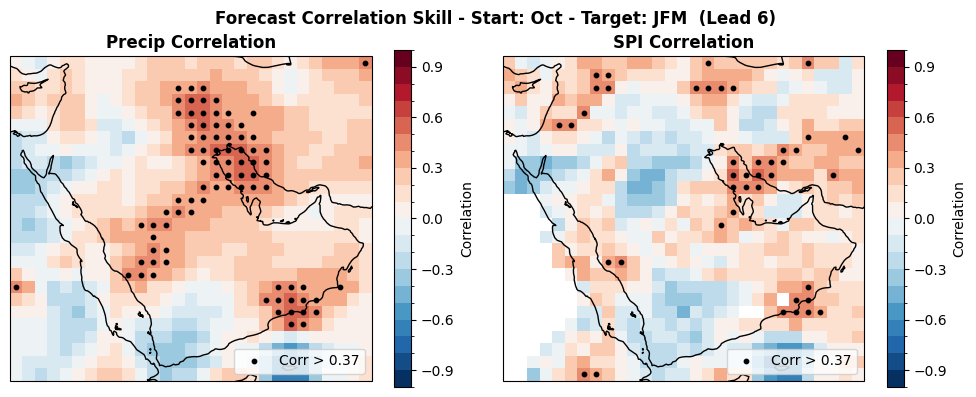

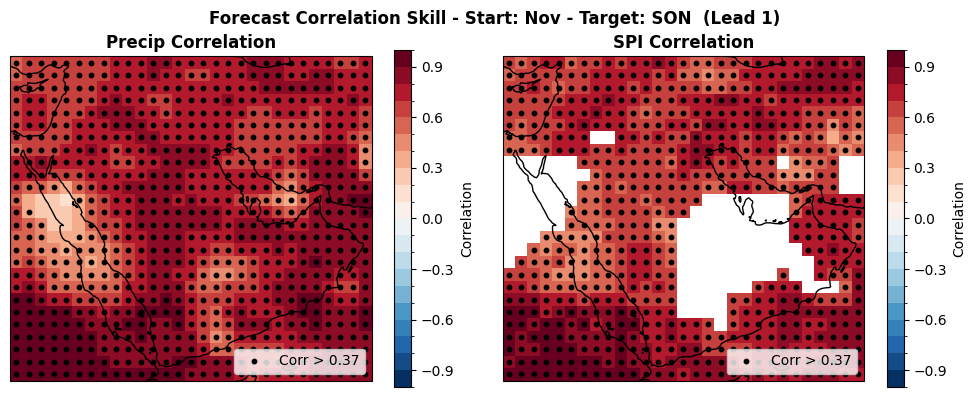

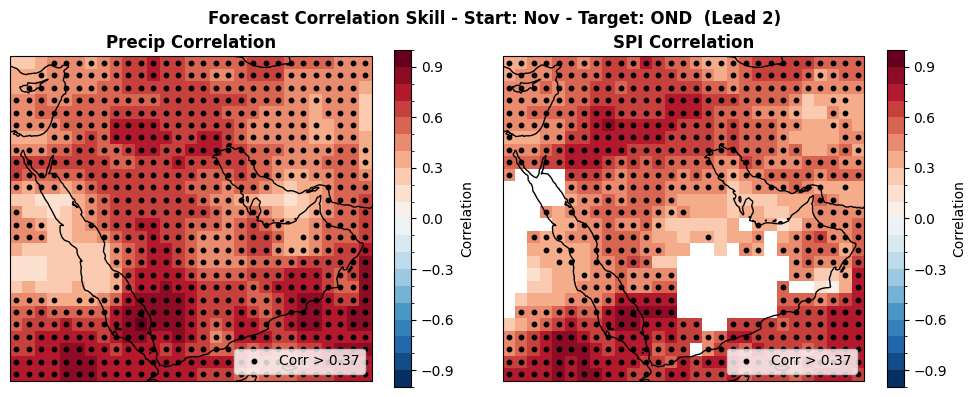

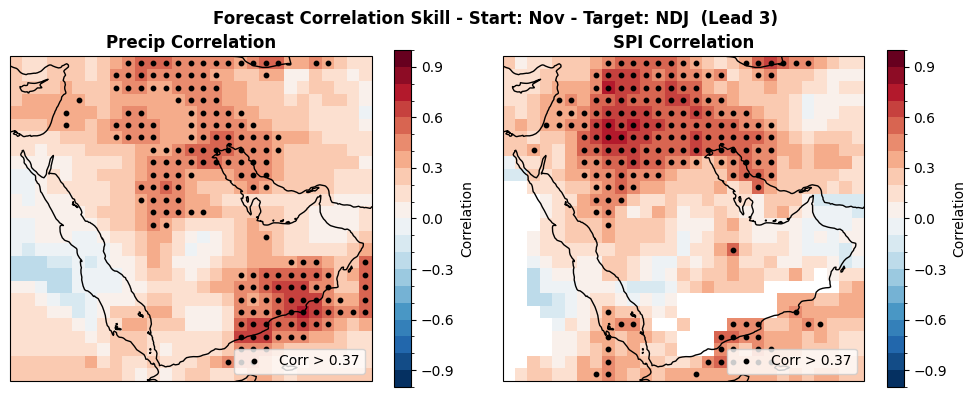

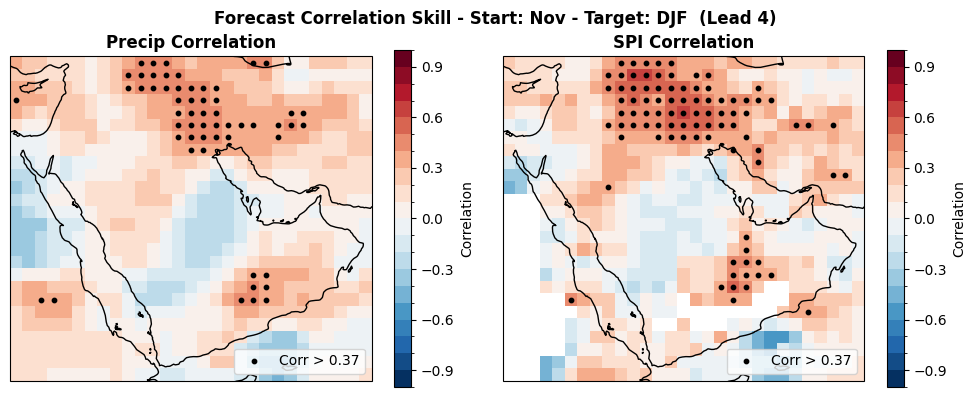

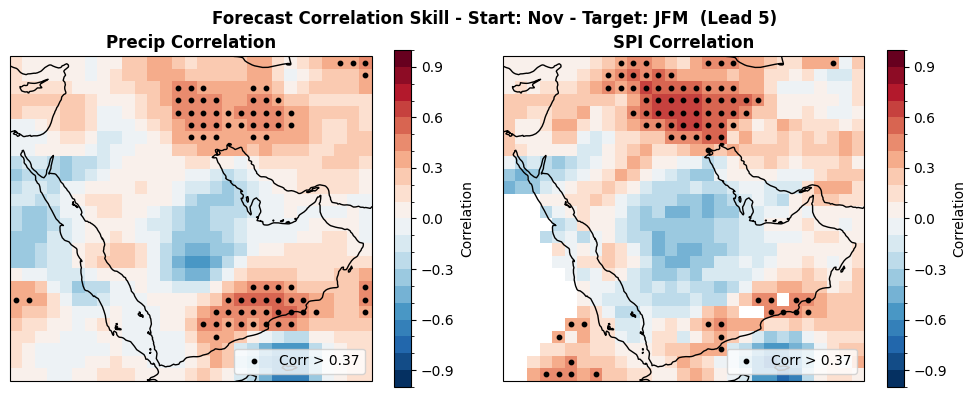

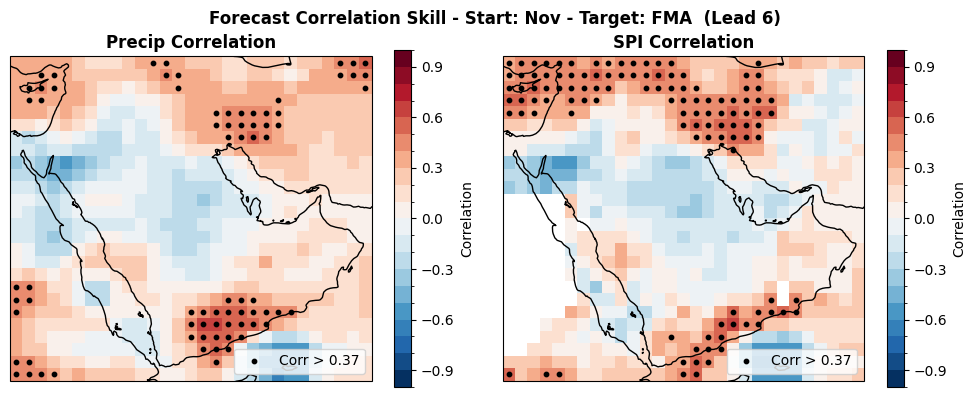

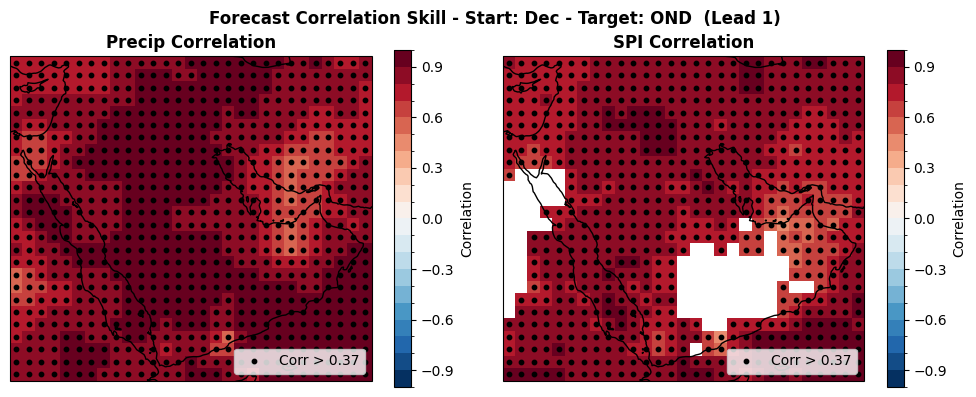

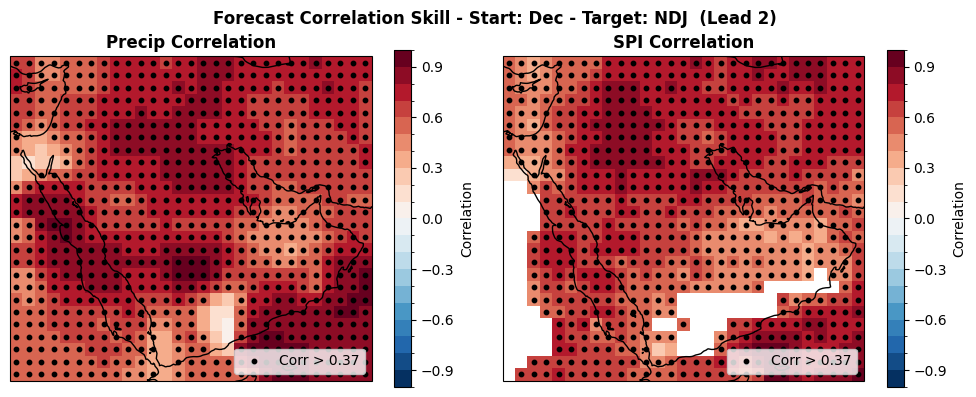

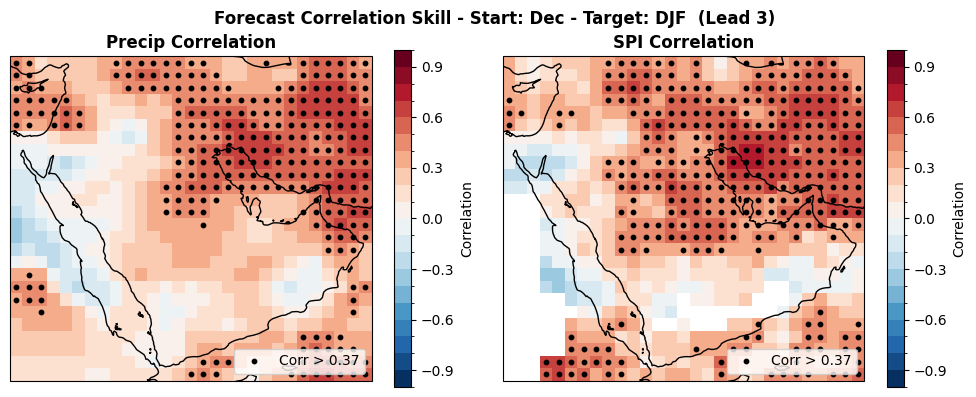

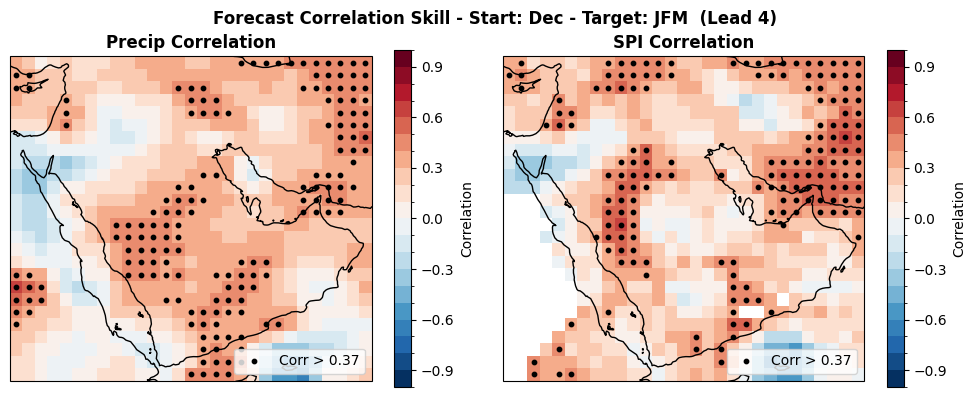

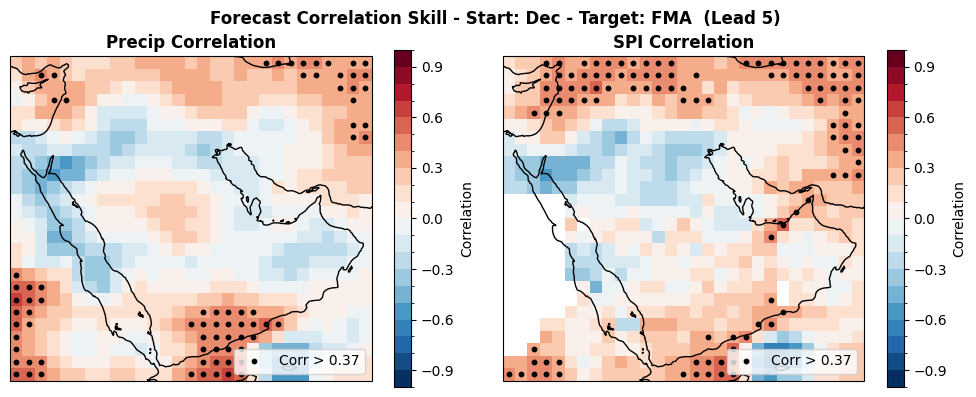

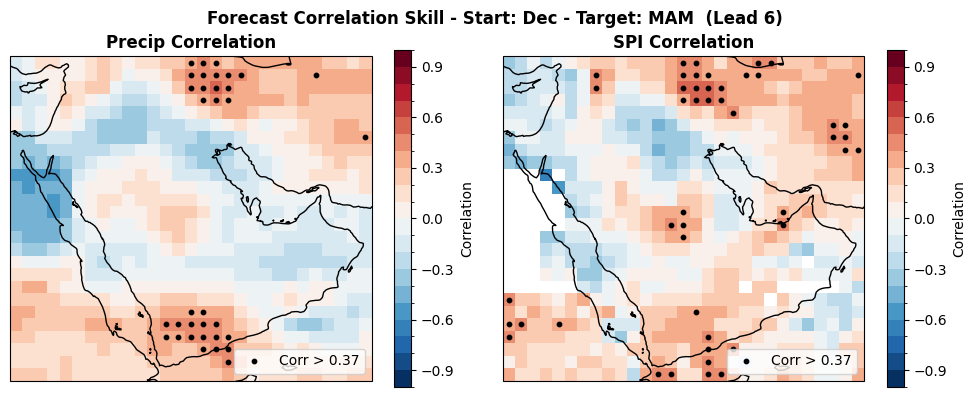

In [13]:
#kepp only forecat with Lead time 0.5 Target date in mon
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasons = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']

threshold = 0.37

for s_month in range(1, 13):
    for lead_time in range(n_lead):
        print(f"Processing month {s_month} with lead time {lead_time+1}")
        t_month = s_month + lead_time
        #have y_month computed as the modulo of 12 but 0 is 12
        t_month = t_month % 12
        if t_month == 0:
            t_month = 12
        season_str = 'Start: ' + months[s_month-1] + ' - ' 'Target: ' + seasons[t_month-1]
        save_str = 'start_' + months[s_month-1] + '_target_' + seasons[t_month-1]


        P_fcst_mon = precip_fcast_multimodel.sel(S=precip_fcast_multimodel['S.month'] == s_month).isel(L=lead_time).drop_vars('L')
        spi_fcst_mon = spi_fcast_multimodel.sel(S=spi_fcast_multimodel['S.month'] == s_month).isel(L=lead_time).drop_vars('L')
        
        #replace S by T and remove S
        S_values = spi_fcst_mon['S'].values
        T_values = [S_value + pd.DateOffset(months=lead_time) for S_value in S_values]
        #remove the S dimension
        P_fcst_mon['S'] = T_values
        spi_fcst_mon['S'] = T_values
        #rename S to T
        P_fcst_mon = P_fcst_mon.rename({'S':'T'})
        spi_fcst_mon = spi_fcst_mon.rename({'S':'T'})

        # Select the correct month for the observations
        P_obs_mon = obs_3m.sel(T=obs_3m['T.month'] == t_month)
        spi_obs_mon = spi_obs.sel(T=spi_obs['T.month'] == t_month)

        #keep same years for obs and forecast
        P_obs_mon = P_obs_mon.sel(T=P_fcst_mon['T'])
        spi_obs_mon = spi_obs_mon.sel(T=spi_fcst_mon['T'])

        ## plot the correlation map

        corr_map_p = xr.corr(P_fcst_mon, P_obs_mon, dim='T')
        corr_map_spi = xr.corr(spi_fcst_mon, spi_obs_mon, dim='T')

        levels = np.arange(-1, 1.1, 0.1)
        fig, axes = plt.subplots(
            nrows=1, ncols=2, figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()}
        )

        # Plot corr_obs_month
        corr_map_p.plot(
            vmin=-1, vmax=1, cmap='RdBu_r', cbar_kwargs={'label': 'Correlation'}, ax=axes[0],
            levels=levels
        )
        axes[0].coastlines()
        avg_corr = corr_map_p.mean().values
        axes[0].set_title(f'Precip Correlation', fontweight='bold')

        # Add dots for values > threshold
        mask_obs = corr_map_p > threshold
        x_obs = corr_map_p.coords['X'].values  # Replace 'lon' with your longitude coord name
        y_obs = corr_map_p.coords['Y'].values  # Replace 'lat' with your latitude coord name
        lon, lat = np.meshgrid(x_obs, y_obs)
        axes[0].scatter(
            lon[mask_obs], lat[mask_obs], color='black', s=10, transform=ccrs.PlateCarree(), label=f'Corr > {threshold}'
        )
        axes[0].legend(loc='lower right')

        # Plot corr_spi_month
        corr_map_spi.plot(
            vmin=-1, vmax=1, cmap='RdBu_r', cbar_kwargs={'label': 'Correlation'}, ax=axes[1],
            levels=levels
        )
        axes[1].coastlines()
        avg_corr = corr_map_spi.mean().values
        axes[1].set_title(f'SPI Correlation', fontweight='bold')

        # Add dots for values > threshold
        mask_spi = corr_map_spi > threshold
        x_spi = corr_map_spi.coords['X'].values
        y_spi = corr_map_spi.coords['Y'].values
        lon, lat = np.meshgrid(x_spi, y_spi)
        axes[1].scatter(
            lon[mask_spi], lat[mask_spi], color='black', s=10, transform=ccrs.PlateCarree(), label=f'Corr > {threshold}'
        )
        axes[1].legend(loc='lower right')

        lead_str = str(lead_time + 1)

        plt.suptitle(f'Forecast Correlation Skill - {season_str}  (Lead {lead_str})', fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'figures/forecast/corr_multimodel_{save_str}.png')

